# Exploration of VGG pre-trained models on Smoke detection dataset

## Importing libraries

In [1]:
# for preprocessing and visualizing the data
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# for training the model
import torch
import torchvision.models as models
import torchvision.datasets as datasets
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)

In [3]:
# more libraries
import os
import random

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.device_count()

1

#### Pre-defined functions

In [6]:
def show_image(inp, title=None):
    """Present image using tensors"""
    inp = cv2.imread(inp)
    inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
    inp = cv2.resize(inp, (224, 224))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()


In [7]:
def present_cm(true_labels, predictions):
  """Present confusion matrix"""

  cm = confusion_matrix(true_labels, predictions)

  print("Confusion Matrix:")
  print(cm)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=model.idx_to_class.values(),
              yticklabels=model.idx_to_class.values())
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

## Exploring the Data

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
print(os.getcwd())
path = '/content/drive/My Drive/Dataset-1/training_data/smoking'
os.chdir(path)
list_of_images = os.listdir()
print(list_of_images)

/content
['smoking_0011.jpg', 'smoking_0018.jpg', 'smoking_0023.jpg', 'smoking_0002.jpg', 'smoking_0005.jpg', 'smoking_0016.jpg', 'smoking_0014.jpg', 'smoking_0010.jpg', 'smoking_0004.jpg', 'smoking_0001.jpg', 'smoking_0021.jpg', 'smoking_0006.jpg', 'smoking_0003.jpg', 'smoking_0017.jpg', 'smoking_0009.jpg', 'smoking_0007.jpg', 'smoking_0019.jpg', 'smoking_0015.jpg', 'smoking_0051.jpg', 'smoking_0092.jpg', 'smoking_0091.jpg', 'smoking_0046.jpg', 'smoking_0045.jpg', 'smoking_0065.jpg', 'smoking_0027.jpg', 'smoking_0074.jpg', 'smoking_0083.jpg', 'smoking_0078.jpg', 'smoking_0068.jpg', 'smoking_0030.jpg', 'smoking_0040.jpg', 'smoking_0064.jpg', 'smoking_0084.jpg', 'smoking_0081.jpg', 'smoking_0095.jpg', 'smoking_0086.jpg', 'smoking_0072.jpg', 'smoking_0062.jpg', 'smoking_0035.jpg', 'smoking_0049.jpg', 'smoking_0052.jpg', 'smoking_0029.jpg', 'smoking_0034.jpg', 'smoking_0082.jpg', 'smoking_0097.jpg', 'smoking_0093.jpg', 'smoking_0047.jpg', 'smoking_0055.jpg', 'smoking_0036.jpg', 'smoking_0

In [10]:
print(os.getcwd())
print(os.listdir())

/content/drive/My Drive/Dataset-1/training_data/smoking
['smoking_0011.jpg', 'smoking_0018.jpg', 'smoking_0023.jpg', 'smoking_0002.jpg', 'smoking_0005.jpg', 'smoking_0016.jpg', 'smoking_0014.jpg', 'smoking_0010.jpg', 'smoking_0004.jpg', 'smoking_0001.jpg', 'smoking_0021.jpg', 'smoking_0006.jpg', 'smoking_0003.jpg', 'smoking_0017.jpg', 'smoking_0009.jpg', 'smoking_0007.jpg', 'smoking_0019.jpg', 'smoking_0015.jpg', 'smoking_0051.jpg', 'smoking_0092.jpg', 'smoking_0091.jpg', 'smoking_0046.jpg', 'smoking_0045.jpg', 'smoking_0065.jpg', 'smoking_0027.jpg', 'smoking_0074.jpg', 'smoking_0083.jpg', 'smoking_0078.jpg', 'smoking_0068.jpg', 'smoking_0030.jpg', 'smoking_0040.jpg', 'smoking_0064.jpg', 'smoking_0084.jpg', 'smoking_0081.jpg', 'smoking_0095.jpg', 'smoking_0086.jpg', 'smoking_0072.jpg', 'smoking_0062.jpg', 'smoking_0035.jpg', 'smoking_0049.jpg', 'smoking_0052.jpg', 'smoking_0029.jpg', 'smoking_0034.jpg', 'smoking_0082.jpg', 'smoking_0097.jpg', 'smoking_0093.jpg', 'smoking_0047.jpg', 'sm

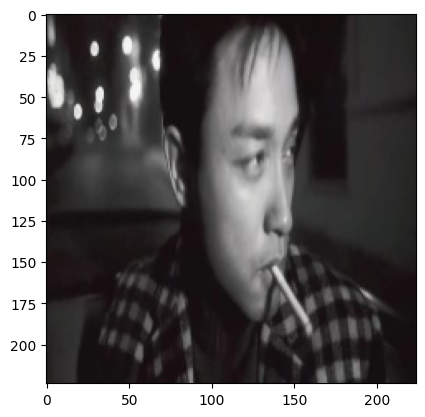

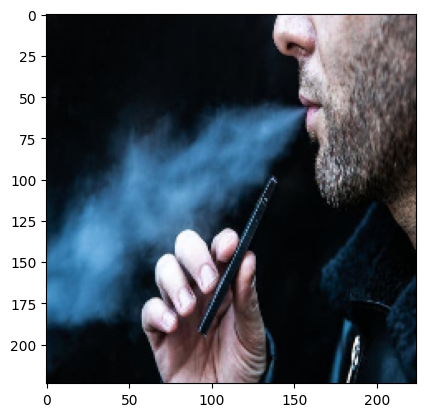

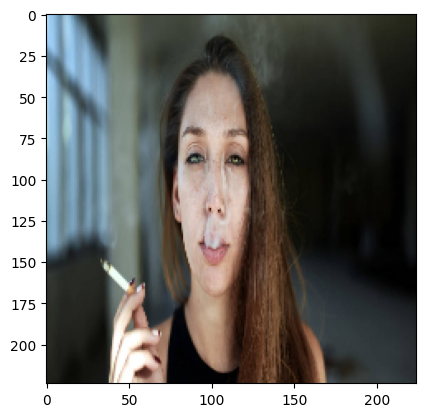

In [11]:
count = 0
for img in list_of_images:
    show_image(img)
    count += 1
    if count >= 3:
        break

Enable the GPU

In [12]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("GPU is available and being used.")
else:
  device = torch.device("cpu")
  print("GPU is not available, using CPU instead.")

GPU is available and being used.


## Data preprocessing

In this section, we will preprocess our dataset by shuffling, resizing and normalizing then converting our images to tensors. This preprocessing technique is the default option in modifying images to make it easier for ML model to learn from it.

In [13]:
print(os.getcwd())
origin_dir = '../../../'
os.chdir(origin_dir)
print(os.getcwd())

/content/drive/MyDrive/Dataset-1/training_data/smoking
/content/drive/MyDrive


In [14]:
training_data = './Dataset-1/training_data'
validating_data = './Dataset-1/validation_data'

data_transformation = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

training_dataset = datasets.ImageFolder(training_data, transform=data_transformation)
validating_datasets = datasets.ImageFolder(validating_data, transform=data_transformation)

In [15]:
training_dataset

Dataset ImageFolder
    Number of datapoints: 1610
    Root location: ./Dataset-1/training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
len(training_dataset.samples)

1610

In [ ]:
validating_datasets

Dataset ImageFolder
    Number of datapoints: 400
    Root location: ./Dataset-1/validation_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

training_dataset = datasets.ImageFolder(training_data, transform=data_transforms)
validating_datasets = datasets.ImageFolder(validating_data, transform=data_transforms)

batch_size = 32
training_dataset_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validating_dataset_loader = DataLoader(validating_datasets, batch_size=1)

In [ ]:
data = iter(training_dataset_loader)
features, labels = next(data)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Training the VGG16 and VGG19 models

In [16]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.5MB/s]


In [ ]:
for param in vgg16.parameters():
    param.requires_grad = False

The following code shows you how many parameters the VGG16 model has and how many parameters after we turned off the learnable parameters and only left the neural network layers.

In [ ]:
total_params = sum(p.numel() for p in vgg16.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in vgg16.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

138,357,544 total parameters.
0 training parameters.


#### Testing the model

In [ ]:
fc_inputs = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1)
)

vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
loss = nn.NLLLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.01)

In [ ]:
# test the model with one batch


X,y = next(iter(training_dataset_loader))
print(X.shape, y.shape)
yHat = vgg16(X)

# now let's compute the loss
loss_result = loss(yHat,y)
print(' ')
print('Loss:')
print(loss_result)

torch.Size([32, 3, 224, 224]) torch.Size([32])
 
Loss:
tensor(0.7426, grad_fn=<NllLossBackward0>)


#### Function to create pretrained model

In [17]:
def get_pretrained_model(model_name, optimizerAlgo, learning_rate):

    if model_name == "vgg16":
        model = models.vgg16(pretrained=True)

        for params in model.parameters():
            params.requires_grad = False

        inputs = model.classifier[6].in_features

        model.classifier[6] = nn.Sequential(
            nn.Linear(inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2),
            nn.LogSoftmax(dim=1)
        )

    loss_func = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # optifun = getattr(torch.optim, optimizerAlgo)
    # optimizer = optifun(model.parameters(), lr=learning_rate)

    return model, loss_func, optimizer

In [18]:
vgg16, criterion, optimizer = get_pretrained_model("vgg16", 0.01)
summary(vgg16, input_size=(3, 224, 224), batch_size=batch_size)

TypeError: get_pretrained_model() missing 1 required positional argument: 'learning_rate'

Mapping of Classes to Indexes. This code will let us know the actual class for a given prediction.

In [ ]:
vgg16.class_to_idx = training_dataset.class_to_idx
vgg16.idx_to_class = {
    idx: class_
    for class_, idx in vgg16.class_to_idx.items()
}

list(vgg16.idx_to_class.items())[:2]

[(0, 'notsmoking'), (1, 'smoking')]

#### Create a function for training the model

In [19]:
def trainTheModel(model, loss, optimizer, train_loader, validate_loader, epochs=5):
  # model, loss, optimizer = get_pretrained_model("vgg16")
  model.to(device)

  train_loss_list = torch.zeros(epochs)
  validation_loss_list = torch.zeros(epochs)
  train_acc_list = []
  validation_acc_list = []

  for epoch in range(epochs):

    train_acc = 0.0
    train_loss = 0.0
    validation_loss = 0.0
    validation_acc = 0.0

    model.train()

    print(f'Epoch {epoch + 1}')
    print('-' * 10)
    for inputs, labels in train_loader:
      # training data to run on GPU
      inputs = inputs.to(device)
      labels = labels.to(device)

      labels = torch.squeeze(labels)

      optimizer.zero_grad()
      label_hat = model(inputs)
      loss_result = loss(label_hat, labels)

      # backpropagation
      loss_result.backward()
      optimizer.step()

      # storing the batch loss
      train_loss += loss_result.item() * inputs.size(0)
      # train_batch_loss.append(train_loss)

      matched = torch.argmax(label_hat.data, axis=1) == labels
      train_acc += 100 * torch.mean(matched.float()) * inputs.size(0)
      # train_batch_acc.append(train_acc)

    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    train_acc_list.append(train_acc)
    train_loss_list[epoch] = train_loss

    with torch.no_grad():
      model.eval()

      for inputs, labels in validate_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # labels = torch.squeeze(labels)

        label_hat = model(inputs)
        loss_result = loss(label_hat, labels)

        validation_loss += loss_result.item() * inputs.size(0)
        # validation_batch_loss.append(validation_loss)

        matched = torch.argmax(label_hat.data, axis=1) == labels
        validation_acc += 100 * torch.mean(matched.float()) * inputs.size(0)
        # validation_batch_acc.append(validation_acc)

      validation_loss = validation_loss / len(validate_loader.dataset)
      validation_acc = validation_acc / len(validate_loader.dataset)

      validation_acc_list.append(validation_acc)
      validation_loss_list[epoch] = validation_loss

      print(
          f'Training Loss: {train_loss:.4f} \t Validation Loss: {validation_loss:.4f}'
      )
      print(
          f'Training Accuracy: {train_acc:.4f} \t Validation Accuracy: {validation_acc:.4f}'
      )

  return model, train_loss_list, validation_loss_list, train_acc_list, validation_acc_list


## Using Confusion Matrix to evaluate our model's performance

#### Create a class for storing test dataset into an ImageDataset object

Since the `testing_data` directory structure isn't similar to the other directories, we'll apply the following technique to store the `testing_data` into a `DataLoader` class

In [23]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class ImageDataset(Dataset):
       def __init__(self, image_dir, transform=None, labels=None):
           self.image_dir = image_dir
           self.image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(('.jpg', '.jpeg', '.png'))]
           self.transform = transform
           self.labels = labels

       def __len__(self):
           return len(self.image_paths)

       def __getitem__(self, idx):
           image_path = self.image_paths[idx]
           image = Image.open(image_path).convert("RGB")

           if self.transform:
               image = self.transform(image)

           label = self.labels[idx] if self.labels is not None else -1

           return image, label


## Performing meta-parameters

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

training_dataset = datasets.ImageFolder(training_data, transform=data_transforms)
validating_datasets = datasets.ImageFolder(validating_data, transform=data_transforms)

#### Performing meta-parameters on different batch sizes

In [ ]:
# Range of batch sizes from 2^1 -> 2^5
batchsizes = 2 ** np.arange(1, 7)
learningRates = np.array([0.0001, 0.001, 0.01, 0.1])

print(f'Batch sizes: {batchsizes}')
print(f'Learning rates: {learningRates}')

epochs = 5
# Initialize output results matrices
accuracyResultsTrain = np.zeros((epochs, len(batchsizes), len(learningRates)))
accuracyResultsValidate = np.zeros((epochs, len(batchsizes), len(learningRates)))
comptime = np.zeros((len(batchsizes), len(learningRates)))

validation_loader = DataLoader(validating_datasets, batch_size=1)

for bi in range(len(batchsizes)):
  print(f'Batch size: {batchsizes[bi]}')
  print(type(batchsizes[bi]))
  print('-' * 20)
  # Create DataLoader object for training data with the current batch size
  train_loader = DataLoader(training_dataset,
                            batch_size=int(batchsizes[bi]), shuffle=True)
  for lr in range(len(learningRates)):
    print(f'Learning rate: {learningRates[lr]}')
    # Start the timer to measure computation time
    starttime = time.process_time()

    # Create and train a model
    trainined_model, criterion, optimizer =  get_pretrained_model("vgg16", learningRates[lr])
    model, train_loss_list, validation_loss_list, train_acc_list, validation_acc_list = trainTheModel(
        trainined_model, criterion, optimizer, train_loader, validation_loader, epochs=epochs
      )

    accuracyResultsTrain[:, bi, lr] = [x.cpu().numpy() for x in train_acc_list]
    accuracyResultsValidate[:, bi, lr] = [x.cpu().numpy() for x in validation_acc_list]

    comptime[bi, lr] = time.process_time() - starttime
    print(f'Computation time: {comptime[bi, lr]}')
    print('-' * 20)


Batch sizes: [ 2  4  8 16 32 64]
Learning rates: [0.0001 0.001  0.01   0.1   ]
Batch size: 2
<class 'numpy.int64'>
--------------------
Learning rate: 0.0001
Epoch 1
----------
Training Loss: 0.6791 	 Validation Loss: 0.6393
Training Accuracy: 56.2112 	 Validation Accuracy: 77.2500
Epoch 2
----------
Training Loss: 0.6270 	 Validation Loss: 0.5816
Training Accuracy: 69.0062 	 Validation Accuracy: 83.7500
Epoch 3
----------
Training Loss: 0.5727 	 Validation Loss: 0.5307
Training Accuracy: 74.6584 	 Validation Accuracy: 83.0000
Epoch 4
----------
Training Loss: 0.5383 	 Validation Loss: 0.4868
Training Accuracy: 77.2050 	 Validation Accuracy: 85.2500
Epoch 5
----------
Training Loss: 0.5078 	 Validation Loss: 0.4552
Training Accuracy: 78.3851 	 Validation Accuracy: 84.5000
Computation time: 498.32615824899995
--------------------
Learning rate: 0.001
Epoch 1
----------
Training Loss: 0.5063 	 Validation Loss: 0.3613
Training Accuracy: 77.7019 	 Validation Accuracy: 85.2500
Epoch 2
-----

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#### Accuracy vs Batch Size

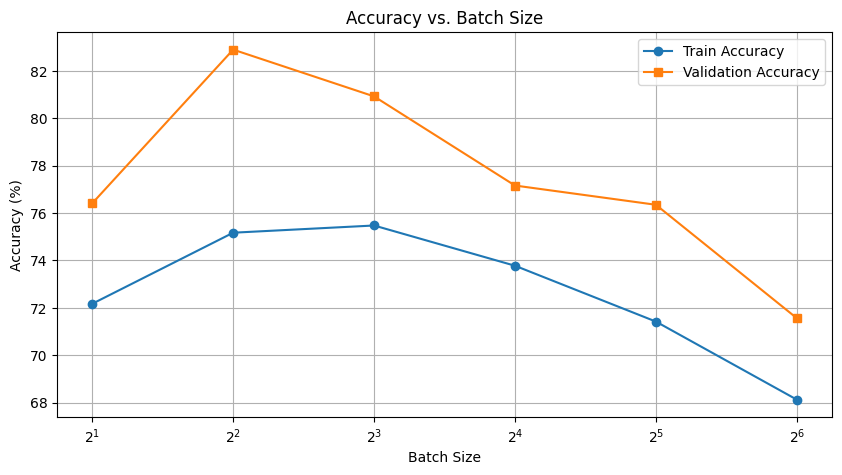

In [ ]:
# Average accuracy over epochs and learning rates for each batch size
mean_train_acc = np.mean(accuracyResultsTrain, axis=(0, 2))  # Average over epochs and learning rates
mean_val_acc = np.mean(accuracyResultsValidate, axis=(0, 2))

plt.figure(figsize=(10, 5))
plt.plot(batchsizes, mean_train_acc, marker='o', label='Train Accuracy')
plt.plot(batchsizes, mean_val_acc, marker='s', label='Validation Accuracy')
plt.xscale('log', base=2)  # Set x-axis to log scale (base 2)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Batch Size')
plt.legend()
plt.grid(True)
plt.show()

#### Accuracy vs Learning Rate

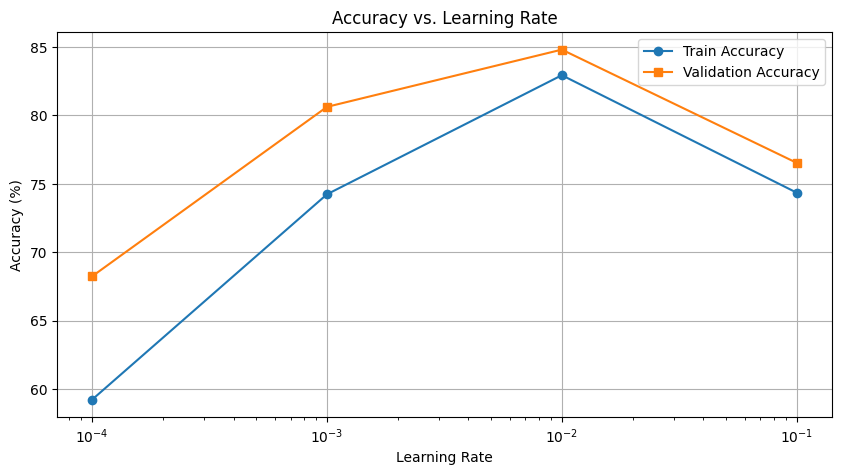

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Average accuracy over epochs and batch sizes for each learning rate
mean_train_acc_lr = np.mean(accuracyResultsTrain, axis=(0, 1))  # Average over epochs and batch sizes
mean_val_acc_lr = np.mean(accuracyResultsValidate, axis=(0, 1))

plt.figure(figsize=(10, 5))
plt.plot(learningRates, mean_train_acc_lr, marker='o', label='Train Accuracy')
plt.plot(learningRates, mean_val_acc_lr, marker='s', label='Validation Accuracy')
plt.xscale('log')  # Set x-axis to log scale
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs. Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

#### Validation Accuracy Heatmap (Batch Size vs. Learning Rate)

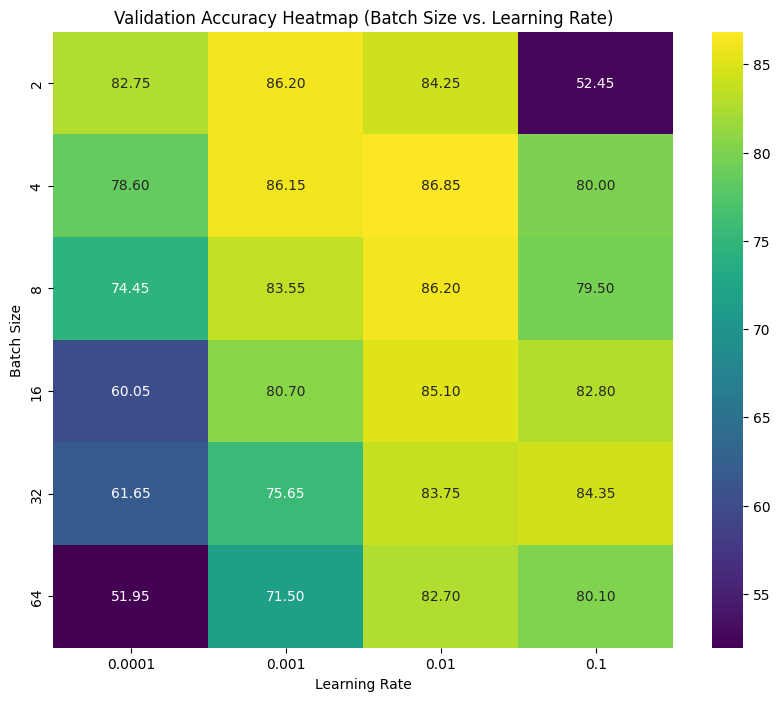

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Average accuracy over epochs for each batch size and learning rate combination
mean_val_acc_heatmap = np.mean(accuracyResultsValidate, axis=0)  # Average over epochs

plt.figure(figsize=(10, 8))
sns.heatmap(mean_val_acc_heatmap, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=learningRates, yticklabels=batchsizes)
plt.xlabel('Learning Rate')
plt.ylabel('Batch Size')
plt.title('Validation Accuracy Heatmap (Batch Size vs. Learning Rate)')
plt.show()

#### Computation Time vs Batch Size

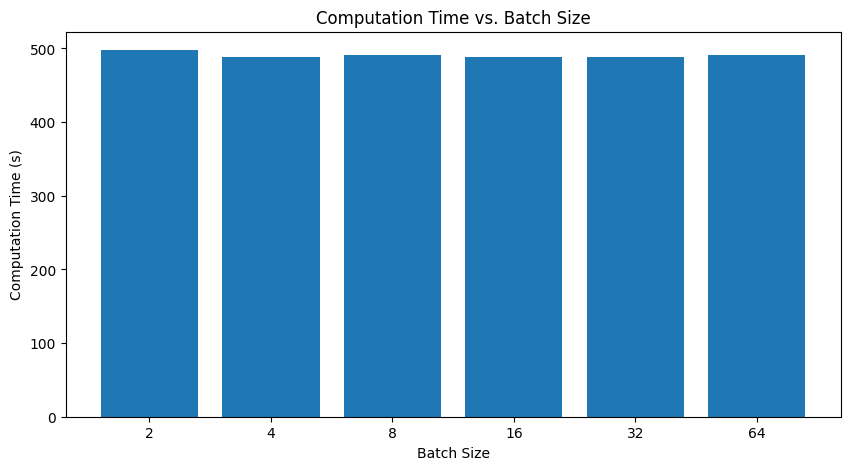

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mean_comptime = np.mean(comptime, axis=1)

plt.figure(figsize=(10, 5))
plt.bar(range(len(batchsizes)), mean_comptime, tick_label=batchsizes)
plt.xlabel('Batch Size')
plt.ylabel('Computation Time (s)')
plt.title('Computation Time vs. Batch Size')
plt.show()

In [ ]:
accuracyResultsTrain

array([[[56.21117783, 77.70185852, 79.25465393, 50.0621109 ],
        [55.03105545, 70.74533844, 80.1863327 , 66.14907074],
        [56.39751434, 64.4720459 , 76.39751434, 73.16770172],
        [49.68944168, 62.23602295, 75.7142868 , 77.39130402],
        [49.31676865, 57.2670784 , 72.23602295, 74.16149139],
        [49.9378891 , 49.68944168, 67.45341492, 73.35403442]],

       [[69.00621033, 82.11180115, 84.65838623, 49.68944168],
        [62.9192543 , 81.98757935, 84.90682983, 67.63974762],
        [56.02484512, 76.89440918, 83.10559082, 79.81365967],
        [51.92546463, 72.11180115, 83.72670746, 82.91925049],
        [50.1242218 , 63.41614914, 81.92546082, 83.47825623],
        [49.00621033, 57.76397324, 78.81987762, 82.29813385]],

       [[74.65838623, 83.47825623, 85.96273041, 51.05590057],
        [68.69564819, 83.22981262, 85.40372467, 69.8757782 ],
        [60.68322754, 81.18012238, 85.7142868 , 79.9378891 ],
        [54.22360229, 76.89440918, 83.91304016, 84.90682983],
    

#### Plotting the training and validation accuracy of each batch size and learning rates

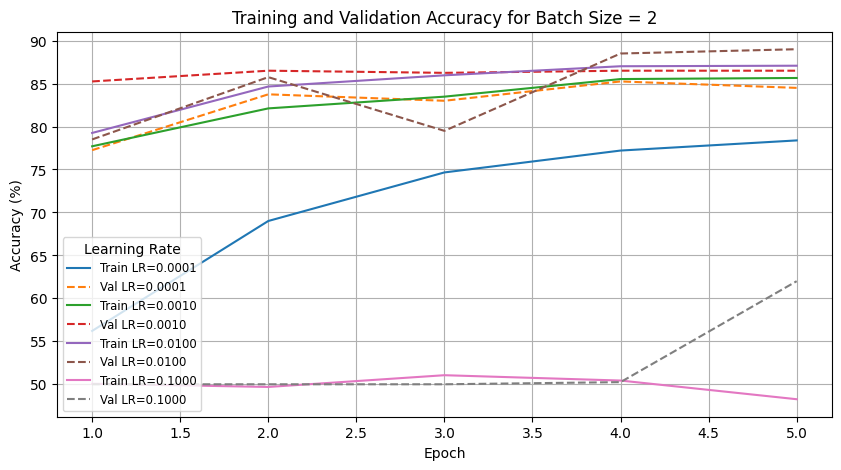

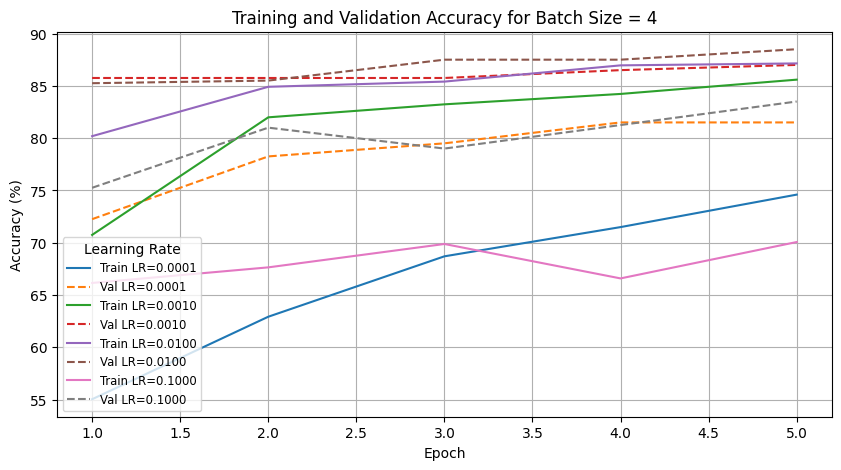

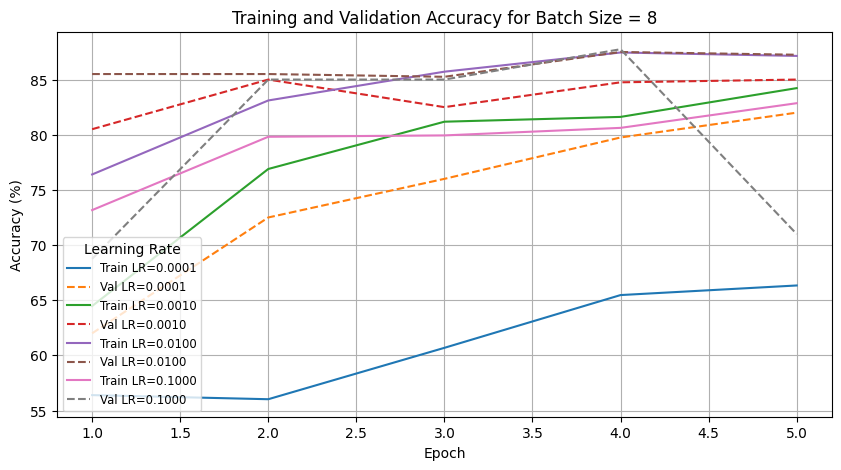

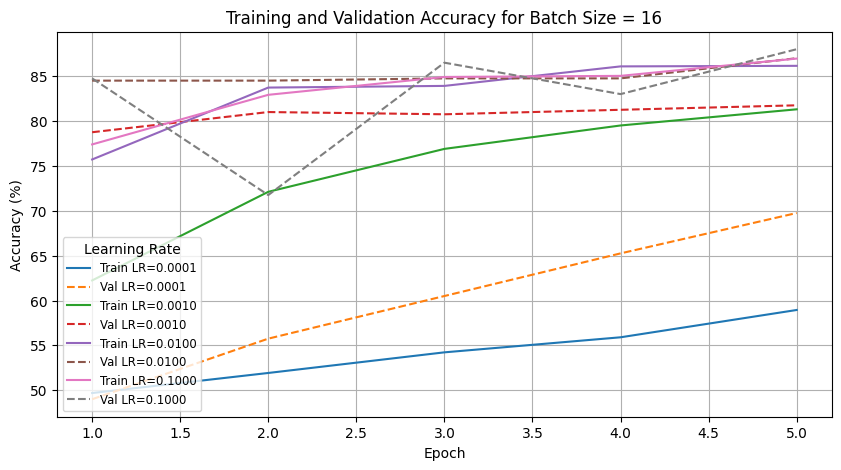

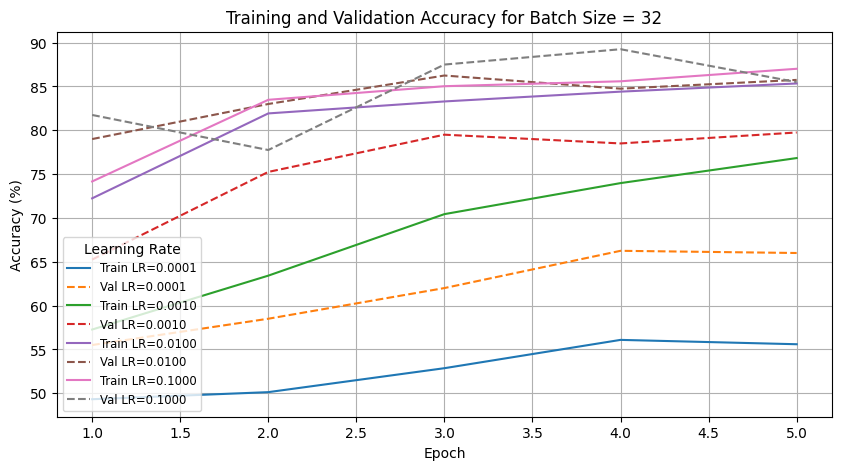

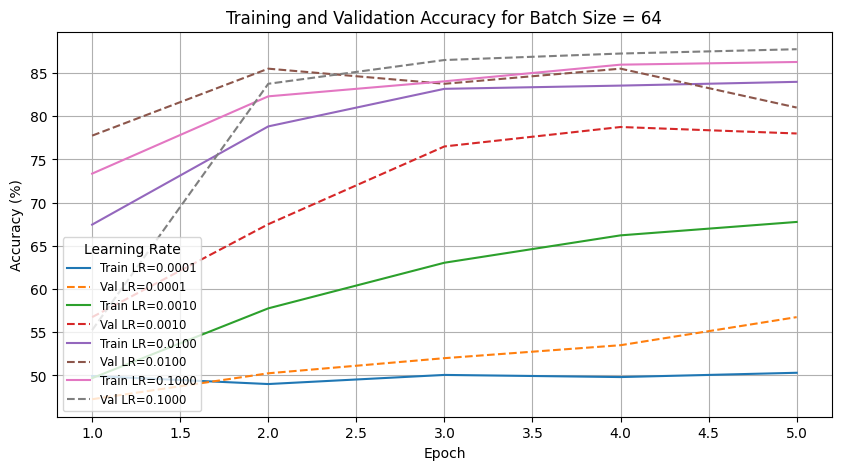

In [ ]:
for bi in range(len(batchsizes)):
    plt.figure(figsize=(10, 5))

    for lr in range(len(learningRates)):
        plt.plot(range(1, epochs + 1), accuracyResultsTrain[:, bi, lr],
                 label=f'Train LR={learningRates[lr]:.4f}')

        plt.plot(range(1, epochs + 1), accuracyResultsValidate[:, bi, lr],
                 label=f'Val LR={learningRates[lr]:.4f}', linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy for Batch Size = {batchsizes[bi]}')
    plt.legend(title='Learning Rate', fontsize='small', loc="lower left")
    plt.grid(True)
    plt.show()


#### Testing different optimizers

In [ ]:
optimizers = ['SGD', 'Adam', 'RMSprop']

epochs = 5

accuracyResultsTrain = np.zeros((epochs, len(optimizers)))
accuracyResultsValidate = np.zeros((epochs, len(optimizers)))

trainin_loader = DataLoader(training_dataset, batch_size=8, shuffle=True)
validation_loader = DataLoader(validating_datasets, batch_size=1)

for idx, optimizer in enumerate(optimizers):
  print(f'Optimizer: {optimizers[idx]}')

  model, criterion, optimizer = get_pretrained_model("vgg16", optimizers[idx], 0.01)
  model, train_loss_list, validation_loss_list, train_acc_list, validation_acc_list = trainTheModel(
      model, criterion, optimizer, trainin_loader, validation_loader, epochs=epochs
    )

  accuracyResultsTrain[:, idx] = [x.cpu().numpy() for x in train_acc_list]
  accuracyResultsValidate[:, idx] = [x.cpu().numpy() for x in validation_acc_list]

Optimizer: SGD


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
----------
Training Loss: 0.4463 	 Validation Loss: 0.4338
Training Accuracy: 78.9441 	 Validation Accuracy: 81.0000
Epoch 2
----------
Training Loss: 0.3642 	 Validation Loss: 0.4042
Training Accuracy: 84.3478 	 Validation Accuracy: 82.7500
Epoch 3
----------
Training Loss: 0.3343 	 Validation Loss: 0.3215
Training Accuracy: 85.0932 	 Validation Accuracy: 87.0000
Epoch 4
----------
Training Loss: 0.3098 	 Validation Loss: 0.3056
Training Accuracy: 85.2795 	 Validation Accuracy: 88.2500
Epoch 5
----------
Training Loss: 0.2933 	 Validation Loss: 0.2950
Training Accuracy: 87.7019 	 Validation Accuracy: 86.5000
Optimizer: Adam
Epoch 1
----------
Training Loss: 1.0334 	 Validation Loss: 0.3658
Training Accuracy: 75.8385 	 Validation Accuracy: 84.2500
Epoch 2
----------
Training Loss: 0.4637 	 Validation Loss: 0.3377
Training Accuracy: 80.5590 	 Validation Accuracy: 86.2500
Epoch 3
----------
Training Loss: 0.4230 	 Validation Loss: 0.3383
Training Accuracy: 82.3602 	 Validation Ac

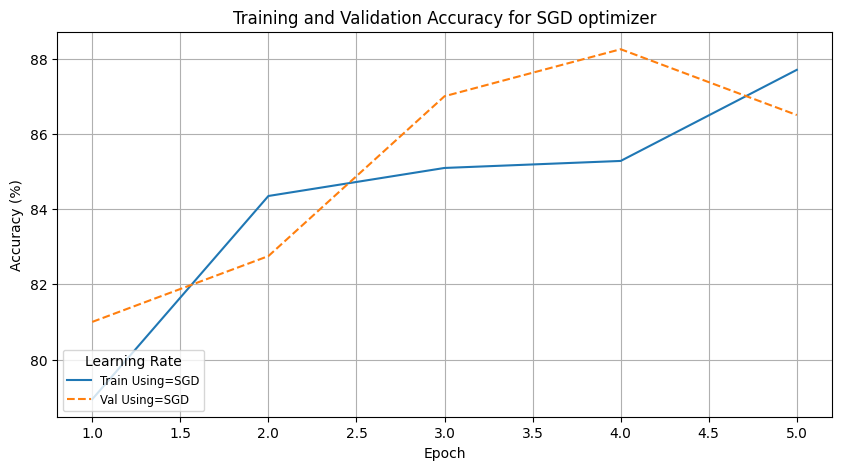

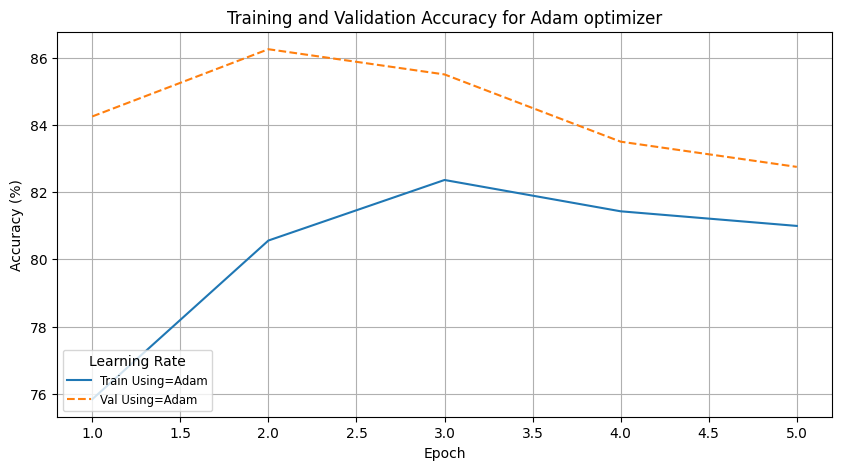

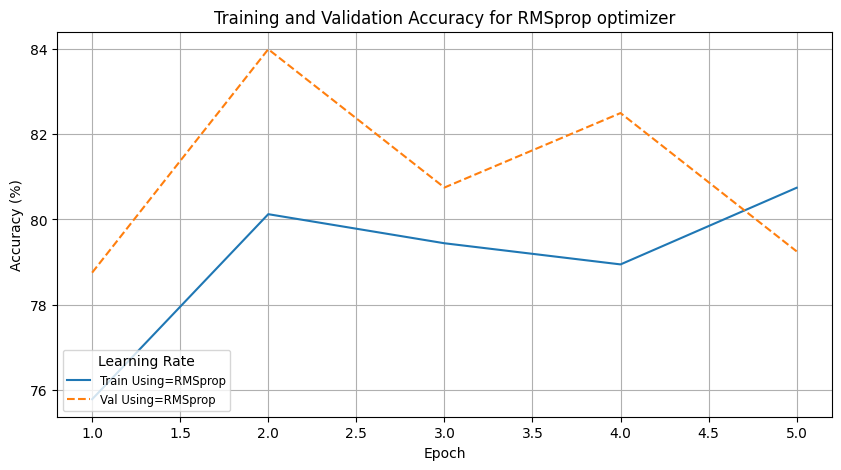

In [ ]:
for idx, optim in enumerate(optimizers):
  plt.figure(figsize=(10, 5))

  plt.plot(range(1, epochs + 1), accuracyResultsTrain[:, idx],
            label=f'Train Using={optim}')

  plt.plot(range(1, epochs + 1), accuracyResultsValidate[:, idx],
            label=f'Val Using={optim}', linestyle='--')

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.title(f'Training and Validation Accuracy for {optim} optimizer')
  plt.legend(title='Learning Rate', fontsize='small', loc="lower left")
  plt.grid(True)
  plt.show()

## Re-training the model

Re-training the model that got the highest validation accuracy from batch size 8 and a learning rate of 0.01 with SGD as its optimizer. This section will be splitted to two parts. The first part we will train the model with the same data specially with the highlighted hyper-paramteres and then evaluate the model using confusion matrix. The second part is the same as the first part but with using Data augmentation technique to extend the dataset and check if the model generalizes better on the extended dataset.

#### Training without Data augmentation

In [ ]:
data_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

training_dataset = datasets.ImageFolder(training_data, transform=data_transforms)
validating_datasets = datasets.ImageFolder(validating_data, transform=data_transforms)

batch_size = 8
training_dataset_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validating_dataset_loader = DataLoader(validating_datasets, batch_size=1)

In [ ]:
model, criterion, optimizer = get_pretrained_model("vgg16", "SGD", 0.01)
model, train_loss_list, validation_loss_list, train_acc_list, validation_acc_list = trainTheModel(model, criterion, optimizer, training_dataset_loader, validating_dataset_loader, epochs=5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
----------
Training Loss: 0.4463 	 Validation Loss: 0.4340
Training Accuracy: 78.9441 	 Validation Accuracy: 81.2500
Epoch 2
----------
Training Loss: 0.3647 	 Validation Loss: 0.4038
Training Accuracy: 84.3478 	 Validation Accuracy: 82.7500
Epoch 3
----------
Training Loss: 0.3337 	 Validation Loss: 0.3229
Training Accuracy: 85.0932 	 Validation Accuracy: 86.2500
Epoch 4
----------
Training Loss: 0.3105 	 Validation Loss: 0.3055
Training Accuracy: 85.4037 	 Validation Accuracy: 88.2500
Epoch 5
----------
Training Loss: 0.2948 	 Validation Loss: 0.2952
Training Accuracy: 87.8261 	 Validation Accuracy: 87.0000


#### Visuliaze the training and validation accuracy

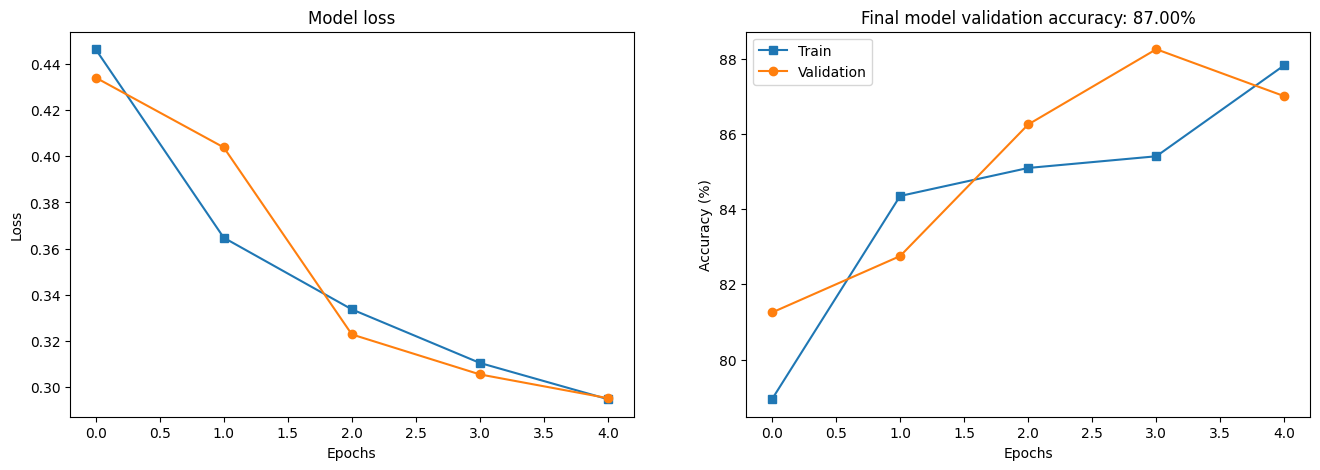

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss_list,'s-')
ax[0].plot(validation_loss_list,'o-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(torch.tensor(train_acc_list).cpu(),'s-',label='Train')
ax[1].plot(torch.tensor(validation_acc_list).cpu(),'o-',label='Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model validation accuracy: {validation_acc_list[-1]:.2f}%')
ax[1].legend()

plt.show()

#### Load the test dataset

In [ ]:
testing_data = './Dataset-1/testing_data'
image_labels = []
print(os.listdir(testing_data))
with os.scandir(testing_data) as entries:
    for idx, entry in enumerate(sorted(entries, key=lambda entry: entry.name)):  # Sort by filename
        if entry.is_file() and entry.name.endswith(('.jpg', '.jpeg', '.png')):
            image_path = entry.path

            if idx < 200:
              label = 1
            else:
              label = 0

            image_labels.append((image_path, label))

# Now, image_labels contains a list of tuples: [(image_path, label), ...]
image_paths = [item[0] for item in image_labels]
labels = [item[1] for item in image_labels]

testing_dataset = ImageDataset(testing_data, transform=data_transforms, labels=labels)

testing_dataset_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

['abc007.jpg', 'abc009.jpg', 'abc004.jpg', 'abc001.jpg', 'abc010.jpg', 'abc006.jpg', 'abc011.jpg', 'abc008.jpg', 'abc005.jpg', 'abc003.jpg', 'abc002.jpg', 'abc046.jpg', 'abc037.jpg', 'abc018.jpg', 'abc023.jpg', 'abc030.jpg', 'abc068.jpg', 'abc042.jpg', 'abc028.jpg', 'abc039.jpg', 'abc022.jpg', 'abc031.jpg', 'abc012.jpg', 'abc043.jpg', 'abc036.jpg', 'abc040.jpg', 'abc048.jpg', 'abc067.jpg', 'abc058.jpg', 'abc056.jpg', 'abc059.jpg', 'abc013.jpg', 'abc066.jpg', 'abc064.jpg', 'abc060.jpg', 'abc026.jpg', 'abc050.jpg', 'abc035.jpg', 'abc017.jpg', 'abc047.jpg', 'abc027.jpg', 'abc045.jpg', 'abc029.jpg', 'abc044.jpg', 'abc021.jpg', 'abc025.jpg', 'abc033.jpg', 'abc019.jpg', 'abc034.jpg', 'abc038.jpg', 'abc020.jpg', 'abc062.jpg', 'abc041.jpg', 'abc016.jpg', 'abc049.jpg', 'abc054.jpg', 'abc051.jpg', 'abc052.jpg', 'abc057.jpg', 'abc014.jpg', 'abc065.jpg', 'abc063.jpg', 'abc055.jpg', 'abc032.jpg', 'abc061.jpg', 'abc024.jpg', 'abc070.jpg', 'abc069.jpg', 'abc053.jpg', 'abc015.jpg', 'abc093.jpg', 'abc1

#### Get the predictions

In [ ]:
# Store predictions and true labels
predictions = []
true_labels = []

# Get predictions
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    for images, labels in testing_dataset_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class labels

        predictions.extend(predicted.cpu().numpy())  # Extend the list with predicted labels
        true_labels.extend(labels.cpu().numpy())  # Extend the list with true labels

#### Generate the confusion matrix

In [ ]:
model.class_to_idx = training_dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:2]

[(0, 'notsmoking'), (1, 'smoking')]

Confusion Matrix:
[[158  38]
 [ 28 172]]


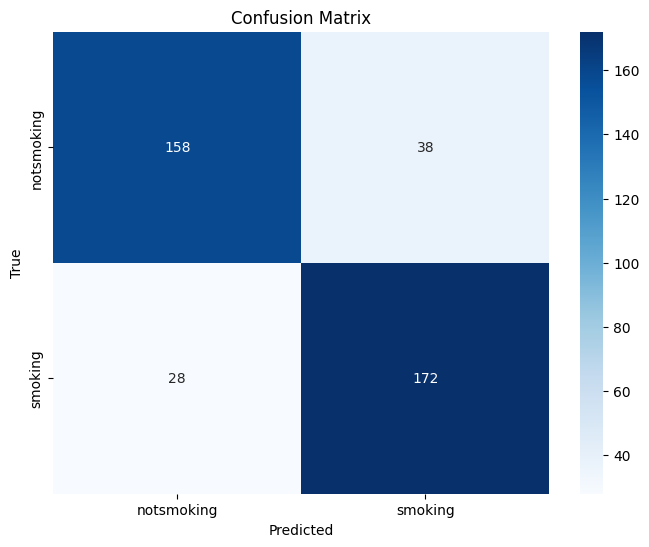

In [ ]:
present_cm(true_labels, predictions)

#### Training with Data augmentation technique

In [20]:
from PIL import Image

In [22]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),       # Horizontal flip
    transforms.RandomRotation(degrees=30),      # Rotate by ±30 degrees
    transforms.ColorJitter(brightness=0.5),     # Random brightness adjustment
])

train_dataset_path = './Dataset-1/training_data'
augmented_training_dataset_path = './Dataset-1/augmented_training_data'

# Create the augmented training dataset directory if it doesn't exist
os.makedirs(augmented_training_dataset_path, exist_ok=True)

for class_path in os.listdir(train_dataset_path):
    class_dir = os.path.join(train_dataset_path, class_path)
    if not os.path.isdir(class_dir):
        continue

    augmented_class_path = os.path.join(augmented_training_dataset_path, class_path)
    os.makedirs(augmented_class_path, exist_ok=True)

    for image_file in tqdm(os.listdir(class_dir), desc=f"Processing {class_dir}"):
        image_path = os.path.join(class_dir, image_file)

        image = Image.open(image_path).convert("RGB")

        image.save(os.path.join(augmented_class_path, image_file))

        for i in range(3):
            augmented_image = augment_transform(image)
            augmented_image_name = f"{os.path.splitext(image_file)[0]}_augmented_{i}.jpg"
            augmented_image.save(os.path.join(augmented_class_path, augmented_image_name))

Processing ./Dataset-1/training_data/smoking: 100%|██████████| 805/805 [02:08<00:00,  6.28it/s]


In [24]:
augmented_training_dataset_path = './Dataset-1/augmented_training_data'
validating_data = './Dataset-1/validation_data'

data_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

training_dataset = datasets.ImageFolder(augmented_training_dataset_path, transform=data_transforms)
validating_datasets = datasets.ImageFolder(validating_data, transform=data_transforms)

batch_size = 8
training_dataset_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
validating_dataset_loader = DataLoader(validating_datasets, batch_size=1)

In [27]:
training_dataset

Dataset ImageFolder
    Number of datapoints: 6440
    Root location: ./Dataset-1/augmented_training_data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [28]:
model, criterion, optimizer = get_pretrained_model("vgg16", "SGD", 0.01)
model, train_loss_list, validation_loss_list, train_acc_list, validation_acc_list = trainTheModel(model, criterion, optimizer, training_dataset_loader, validating_dataset_loader, epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
----------
Training Loss: 0.4294 	 Validation Loss: 0.3091
Training Accuracy: 80.5590 	 Validation Accuracy: 85.7500
Epoch 2
----------
Training Loss: 0.3564 	 Validation Loss: 0.2969
Training Accuracy: 84.7981 	 Validation Accuracy: 86.0000
Epoch 3
----------
Training Loss: 0.3352 	 Validation Loss: 0.2925
Training Accuracy: 85.2795 	 Validation Accuracy: 87.0000
Epoch 4
----------
Training Loss: 0.3148 	 Validation Loss: 0.2892
Training Accuracy: 86.4752 	 Validation Accuracy: 87.0000
Epoch 5
----------
Training Loss: 0.3014 	 Validation Loss: 0.2737
Training Accuracy: 87.4845 	 Validation Accuracy: 86.5000
Epoch 6
----------
Training Loss: 0.2856 	 Validation Loss: 0.2736
Training Accuracy: 87.8416 	 Validation Accuracy: 86.5000
Epoch 7
----------
Training Loss: 0.2717 	 Validation Loss: 0.2569
Training Accuracy: 88.9752 	 Validation Accuracy: 89.2500
Epoch 8
----------
Training Loss: 0.2571 	 Validation Loss: 0.2606
Training Accuracy: 89.0994 	 Validation Accuracy: 87.5000


#### Validating the loss and accuracy (Augmented Dataset)

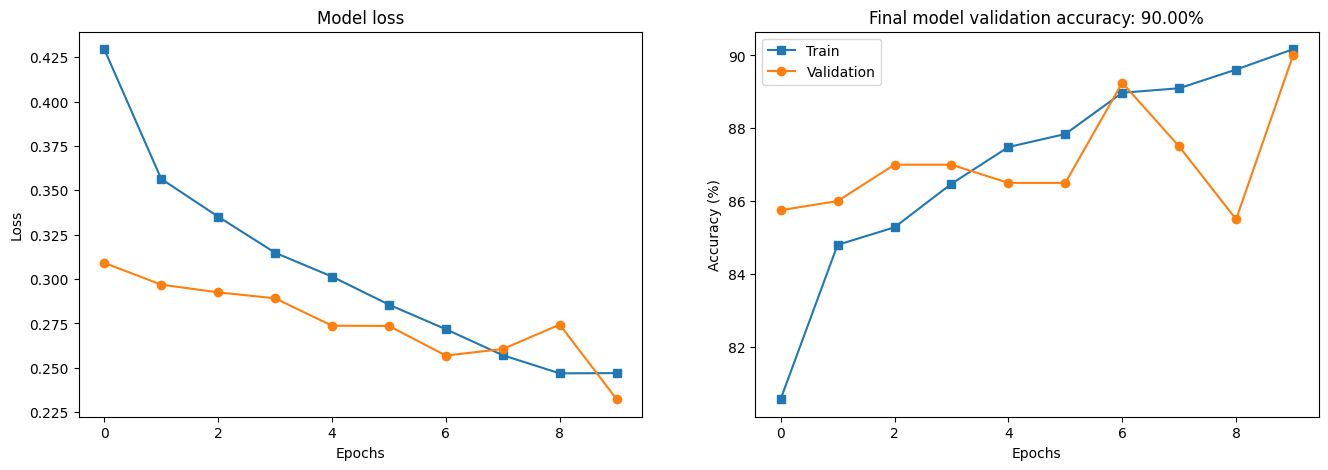

In [29]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss_list,'s-')
ax[0].plot(validation_loss_list,'o-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(torch.tensor(train_acc_list).cpu(),'s-',label='Train')
ax[1].plot(torch.tensor(validation_acc_list).cpu(),'o-',label='Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model validation accuracy: {validation_acc_list[-1]:.2f}%')
ax[1].legend()

plt.show()

In [30]:
testing_data = './Dataset-1/testing_data'
image_labels = []
print(os.listdir(testing_data))
with os.scandir(testing_data) as entries:
    for idx, entry in enumerate(sorted(entries, key=lambda entry: entry.name)):  # Sort by filename
        if entry.is_file() and entry.name.endswith(('.jpg', '.jpeg', '.png')):
            image_path = entry.path

            if idx < 200:
              label = 1
            else:
              label = 0

            image_labels.append((image_path, label))

# Now, image_labels contains a list of tuples: [(image_path, label), ...]
image_paths = [item[0] for item in image_labels]
labels = [item[1] for item in image_labels]

testing_dataset = ImageDataset(testing_data, transform=data_transforms, labels=labels)

testing_dataset_loader = DataLoader(testing_dataset, batch_size=1, shuffle=False)

['abc007.jpg', 'abc009.jpg', 'abc004.jpg', 'abc001.jpg', 'abc010.jpg', 'abc006.jpg', 'abc011.jpg', 'abc008.jpg', 'abc005.jpg', 'abc003.jpg', 'abc002.jpg', 'abc046.jpg', 'abc037.jpg', 'abc018.jpg', 'abc023.jpg', 'abc030.jpg', 'abc068.jpg', 'abc042.jpg', 'abc028.jpg', 'abc039.jpg', 'abc022.jpg', 'abc031.jpg', 'abc012.jpg', 'abc043.jpg', 'abc036.jpg', 'abc040.jpg', 'abc048.jpg', 'abc067.jpg', 'abc058.jpg', 'abc056.jpg', 'abc059.jpg', 'abc013.jpg', 'abc066.jpg', 'abc064.jpg', 'abc060.jpg', 'abc026.jpg', 'abc050.jpg', 'abc035.jpg', 'abc017.jpg', 'abc047.jpg', 'abc027.jpg', 'abc045.jpg', 'abc029.jpg', 'abc044.jpg', 'abc021.jpg', 'abc025.jpg', 'abc033.jpg', 'abc019.jpg', 'abc034.jpg', 'abc038.jpg', 'abc020.jpg', 'abc062.jpg', 'abc041.jpg', 'abc016.jpg', 'abc049.jpg', 'abc054.jpg', 'abc051.jpg', 'abc052.jpg', 'abc057.jpg', 'abc014.jpg', 'abc065.jpg', 'abc063.jpg', 'abc055.jpg', 'abc032.jpg', 'abc061.jpg', 'abc024.jpg', 'abc070.jpg', 'abc069.jpg', 'abc053.jpg', 'abc015.jpg', 'abc093.jpg', 'abc1

In [31]:
predictions = []
true_labels = []

with torch.no_grad():
    model.eval()
    for images, labels in testing_dataset_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [32]:
model.class_to_idx = training_dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:2]

[(0, 'notsmoking'), (1, 'smoking')]

Confusion Matrix:
[[170  26]
 [ 23 177]]


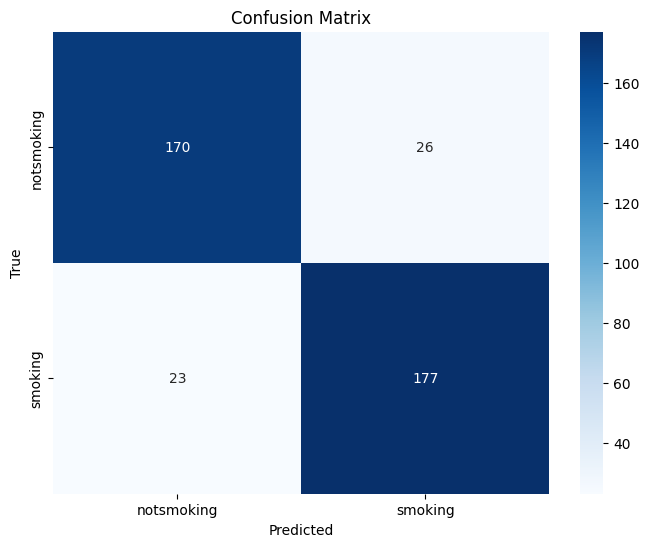

In [33]:
present_cm(true_labels, predictions)